In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import random



In [3]:
df = pd.read_csv(r'Graduation_project/preprocessing_data.csv')

In [4]:
df_analysis = df.copy()

In [5]:
num = ["height" , "weight", "ap_hi" , "ap_lo" , "age_years"]

In [6]:
X_scaled=df[num].values
print(f"Loaded scaled data with shape: {X_scaled.shape}")

Loaded scaled data with shape: (68758, 5)


In [7]:
K_CLUSTERS = 6
print(f"\nApplying KMeans with k={K_CLUSTERS}")
kmeans = KMeans(
    n_clusters=K_CLUSTERS,
    init='k-means++',
    max_iter=300,
    n_init=10,
    random_state=42
)
kmeans_labels = kmeans.fit_predict(X_scaled)
print("KMeans Clustering completed.")


Applying KMeans with k=6
KMeans Clustering completed.


In [8]:
print("\nApplying DBSCAN for outlier detection...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df)

outliers_count = (dbscan_labels == -1).sum()
print(f"DBSCAN Outlier Detection completed. Found {outliers_count} outliers.")


Applying DBSCAN for outlier detection...
DBSCAN Outlier Detection completed. Found 30867 outliers.


In [9]:

print("\nApplying Agglomerative Clustering (Hierarchical) on a sample...")

HIERARCHICAL_SAMPLE_SIZE = 5000
random.seed(42)

agg_indices = random.sample(range(X_scaled.shape[0]), HIERARCHICAL_SAMPLE_SIZE)
X_agg_sample = X_scaled[agg_indices]

agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_labels_sample = agg_clustering.fit_predict(X_agg_sample)

df_analysis.loc[agg_indices, 'Hierarchical_Cluster'] = agg_labels_sample

print(f"Agglomerative Clustering completed on a sample of {HIERARCHICAL_SAMPLE_SIZE} patients.")


Applying Agglomerative Clustering (Hierarchical) on a sample...
Agglomerative Clustering completed on a sample of 5000 patients.


In [13]:
feature_cols = ["height" , "weight", "ap_hi" , "ap_lo" , "age_years"] 
df_analysis = pd.DataFrame(
    np.random.rand(68758, 5), columns=feature_cols
)
df_analysis['KMeans_Cluster'] = kmeans_labels
df_analysis['DBSCAN_Outlier'] = dbscan_labels

In [14]:
TSNE_SAMPLE_SIZE = 5000
np.random.seed(42)
tsne_indices = np.random.choice(range(68758), TSNE_SAMPLE_SIZE, replace=False)
X_tsne_sample = X_scaled[tsne_indices]
tsne_cluster_labels = kmeans_labels[tsne_indices]

print(f"\nRunning t-SNE on a sample of {TSNE_SAMPLE_SIZE} patients...")
tsne = TSNE(
    n_components=2,
    perplexity=30, 
    n_iter=1000,
    random_state=42
)
X_tsne = tsne.fit_transform(X_tsne_sample)


Running t-SNE on a sample of 5000 patients...


c:\Users\SHREEN\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


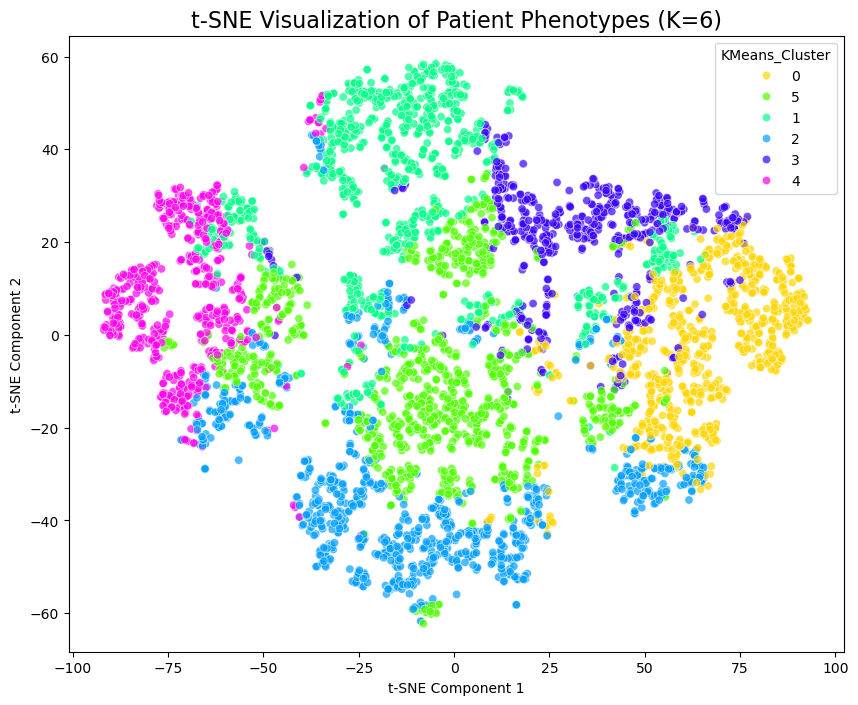

In [15]:
tsne_df = pd.DataFrame(
    data=X_tsne,
    columns=['tSNE_Component_1', 'tSNE_Component_2']
)
tsne_df['KMeans_Cluster'] = tsne_cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tSNE_Component_1',
    y='tSNE_Component_2',
    hue=tsne_df['KMeans_Cluster'].astype(str),
    palette=sns.color_palette("hsv", K_CLUSTERS),
    data=tsne_df,
    legend="full",
    alpha=0.7
)
plt.title(f't-SNE Visualization of Patient Phenotypes (K={K_CLUSTERS})', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [16]:
print("\n--- Cluster Profiling: Clinical Statistics ---")
ORIGINAL_CLINICAL_FEATURES = ['height', 'weight', 'ap_hi', 'ap_lo', 'age_years']
cluster_profiles =df_analysis.groupby('KMeans_Cluster').agg(
    patient_count=('KMeans_Cluster', 'size'),
    **{f'Avg_{col}': (col, 'mean') for col in ORIGINAL_CLINICAL_FEATURES}
).reset_index()


--- Cluster Profiling: Clinical Statistics ---


In [17]:
outlier_percentage = (df_analysis[df_analysis['DBSCAN_Outlier'] == -1]
                      .groupby('KMeans_Cluster').size() /
                      df_analysis.groupby('KMeans_Cluster').size() * 100).fillna(0).reset_index(name='Outlier_Percentage')

cluster_profiles = cluster_profiles.merge(outlier_percentage, on='KMeans_Cluster', how='left').fillna(0)

print("Cluster Profiles (First 5 Rows):")
print(cluster_profiles.head())
print("\nFinal analysis dataframe ready with 'KMeans_Cluster' and 'DBSCAN_Outlier' columns.")

Cluster Profiles (First 5 Rows):
   KMeans_Cluster  patient_count  Avg_height  Avg_weight  Avg_ap_hi  \
0               0          11178    0.500218    0.497087   0.498169   
1               1          13449    0.502449    0.498244   0.499010   
2               2          13306    0.499692    0.497467   0.500307   
3               3           7404    0.500791    0.495728   0.495587   
4               4           7838    0.500373    0.506128   0.503515   

   Avg_ap_lo  Avg_age_years  Outlier_Percentage  
0   0.505420       0.501649           63.955985  
1   0.497447       0.504064           34.537884  
2   0.501876       0.504362           35.442657  
3   0.496491       0.500099           76.566721  
4   0.500760       0.495026           44.769074  

Final analysis dataframe ready with 'KMeans_Cluster' and 'DBSCAN_Outlier' columns.
